In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it
import matplotlib.animation as ani
import copy

# Simulation

In [2]:
colour_dict = {" ":"w.", "S":"b.", "E":"y.", "I":"r.", "R":"g.", "D":"k."}

In [3]:
def generate_city(xmax = 10, ymax = 10, density = 1, infected = 1):
    '''
    Outpus a matrix of size (xmax,ymax)
    density: Value in [0,1] which is the proportion of cells that are populated
    infected: Positive integer which is the number of initially infected cells
    '''
    assert density<=1 and density>=0
    populated = round(xmax * ymax * density)
    susceptible = populated - infected
    empty = xmax * ymax - populated
    
    city = np.random.choice([" "]*empty + ["S"]*susceptible + ["I"]*infected, size = xmax * ymax, replace = False)
    city = np.reshape(city, (xmax,ymax))
    
    return city

In [4]:
def render_city(city):
    '''
    Renders an input city matrix using matplotlib.pyplot imported as plt
    '''
    xmax, ymax = np.shape(city)
    plt.figure(figsize = [xmax/4, ymax/4])
    for x in range(xmax):
        for y in range(ymax):
            plt.plot([x+1], [y+1], colour_dict[city[x,y]], markersize=15)
    plt.xticks([])
    plt.yticks([])
    plt.xlim([-0.2, xmax + 1.2])
    plt.ylim([-0.2, ymax + 1.2])
    return plt.show()

In [5]:
def count_infected(city, x, y):
    '''
    Counts the number if infected cells surrounding cell (x,y) in a city
    '''
    xmax, ymax = np.shape(city)
    count = 0
    for a in range(x-1, x+2):
        if a in range(xmax):
            for b in range(y-1, y+2):
                if b in range(ymax):
                    if city[a,b] == "I" and not (a == x and b == y):
                        count+=1
                        
    return count

In [6]:
def SIR_day(city, p_infect = 0.1, p_recover = 0.2):
    '''
    Outputs a city after one day according to given parameters
    p_infect: Probability an infected individual infects one of it's neighbours on a given day
    p_recover: Probability an infected individual recovers on a given day
    '''
    xmax, ymax = np.shape(city)
    newcity = copy.deepcopy(city)
    for x in range(xmax):
        for y in range(ymax):
            
            # individual is susceptible
            if city[x,y] == "S":
                infected_neighbours = count_infected(city, x, y)
                p0 = (1-p_infect) ** infected_neighbours
                newcity[x,y] = np.random.choice(["S", "I"], p = [p0, 1-p0])
            
            # individual is infected
            elif city[x,y] == "I":
                newcity[x,y] = np.random.choice(["I", "R"], p = [1-p_recover, p_recover])
                
            else:
                newcity[x,y] = copy.copy(city[x,y])
                
    return newcity

In [7]:
def SIRD_day(city, p_infect = 0.1, p_remove = 0.2, p_death = 0.1):
    '''
    Outputs a city after one day according to given parameters
    p_infect: Probability an infected individual infects one of it's neighbours on a given day
    p_remove: Probability an infected individual is recovers/dies on a given day
    p_death: Probability an infected individual dies when they are removed
    '''
    xmax, ymax = np.shape(city)
    newcity = copy.deepcopy(city)
    for x in range(xmax):
        for y in range(ymax):
            
            # individual is susceptible
            if city[x,y] == "S":
                infected_neighbours = count_infected(city, x, y)
                p0 = (1-p_infect) ** infected_neighbours
                newcity[x,y] = np.random.choice(["S", "I"], p = [p0, 1-p0])
            
            # individual is infected
            elif city[x,y] == "I":
                newcity[x,y] = np.random.choice(["I", "R", "D"], p = [1-p_remove, p_remove*(1-p_death), p_remove*p_death])
                
            else:
                newcity[x,y] = copy.copy(city[x,y])
                
    return newcity

In [8]:
def SEIRD_day(city, incubation_time = 0.1,p_infect = 0.1, p_remove = 0.2, p_death = 0.1):
    '''
    Outputs a city after one day according to given parameters
    incubation_time: 1/average time for an exposed individual to become infected
    p_infect: Probability an infected individual infects one of it's neighbours on a given day
    p_remove: Probability an infected individual is recovers/dies on a given day
    p_death: Probability an infected individual dies when they are removed
    '''
    xmax, ymax = np.shape(city)
    newcity = copy.deepcopy(city)
    for x in range(xmax):
        for y in range(ymax):
            
            # individual is susceptible
            if city[x,y] == "S":
                infected_neighbours = count_infected(city, x, y)
                p0 = (1-p_infect) ** infected_neighbours
                newcity[x,y] = np.random.choice(["S", "E"], p = [p0, 1-p0])
            
            # individual is exposed
            elif city[x,y] == "E":
                newcity[x,y] = np.random.choice(["E", "I"], p = [1-incubation_time, incubation_time])
            
            # individual is infected
            elif city[x,y] == "I":
                newcity[x,y] = np.random.choice(["I", "R", "D"], p = [1-p_remove, p_remove*(1-p_death), p_remove*p_death])
                
            else:
                newcity[x,y] = copy.copy(city[x,y])
                
    return newcity

In [9]:
def city_movers(city, p_movement = 0.05, non_movers = ["D"]):
    '''
    Shuffles a proportion of cells in a city
    p_movement: Probability each individual cell decides to move in a given day
    non_movers: A list of cell types that can't move
    
    note: movers are allowed to move to the cell they were from, effectively not moving
    '''
    xmax, ymax = np.shape(city)
    newcity = copy.deepcopy(city)
    n = xmax * ymax
    n_movers = np.random.binomial(n, p_movement)

    old_movers = np.random.choice(range(xmax * ymax), replace=False, size = n_movers)
    new_movers = np.random.choice(old_movers, replace=False, size = n_movers)
    
    old_movers = list(zip(old_movers//ymax, old_movers%xmax))
    new_movers = list(zip(new_movers//ymax, new_movers%xmax))
    
    copy_movers = copy.copy(old_movers)
    
    for x in copy_movers:
        if city[x] in non_movers:
            old_movers.remove(x)
            new_movers.remove(x)
            n_movers -= 1

    for i in range(n_movers):
        newcity[new_movers[i]] = city[old_movers[i]]
    
    moves = [j[0]+1 for j in new_movers], [j[1]+1 for j in new_movers] 
    
    return newcity, moves

In [10]:
def render_city_ax(city):
    '''
    Renders an input city matrix using matplotlib.pyplot imported as plt (used for animations)
    '''
    x0, y0 = np.shape(city)
    for x in range(x0):
        for y in range(y0):
            ax.plot([x+1], [y+1], colour_dict[city[x,y]], markersize=15)

In [11]:
def render_city_moves_ax(city):
    '''
    Renders an input city matrix using matplotlib.pyplot imported as plt (used for animations)
    '''
    x0, y0 = np.shape(city[0])
    for x in range(x0):
        for y in range(y0):
            ax.plot([x+1], [y+1], colour_dict[city[0][x,y]], markersize=15)

    if len(city[1]) > 1:
        ax.plot(city[1][0], city[1][1], "w.", markersize = 6)

In [12]:
def simulate(xmax = 10, ymax = 10, density = 1, infected = 1, simulation_type = "SIR",
            incubation_rate = 0.1, p_infect = 0.1, p_remove = 0.2, p_death = 0.1, max_length = 200,
            movement = False, p_movement = 0.05, non_movers = ["D"],
            lthreshold = 1, ltemporary = True, lp_infect = 0.05, lp_movement = 0.025):
    '''
    Simulates a city until the number of infected cells is 0
    Returns in order a list of city states, a list of t, S, I, R, D values associated with that time
    
    The city size is given by (xmax,ymax)
    density: Value in [0,1] which is the proportion of cells that are populated
    infected: Positive integer which is the number of initially infected cells
    simulation_type: currently supports SIR, SIRD and SEIRD
    
    incubation_rate: 1/average time for an exposed individual to become infected
    p_infect: Probability an infected individual infects one of it's neighbours on a given day
    p_remove: Probability an infected individual is recovers/dies on a given day
    p_death: Probability an infected individual dies when they are removed
    max_length: Maximum number of days until the simulation automatically ends even if there are still infected individuals
    
    movement: Boolean value which enables/disables cell; movement
    p_movement: Probability each individual cell decides to move in a given day
    non_movers: A list of cell types that can't move    
    (note) movers are allowed to move to the cell they were from, effectively not moving
    
    lthreshold: A float between 0 and 1, when the proportion infected cells exceeds this value a lockdown begins, if the value is 1 a lockdown never occurs
    ltemporary: Boolean value, if False, then once a lockdown begins it remains for the entire simulation
    lp_infect: p_infect during a lockdown
    lp_movement: p_movement during a lockdown
    '''
    city = generate_city(xmax, ymax, density, infected)
    cities = [city]
    population = [np.sum(city != " ")]
    moves = [[]]
    lockdown = False
    t = [0]
    S = [np.sum(city == "S")]
    E = [np.sum(city == "E")]
    I = [np.sum(city == "I")]
    R = [np.sum(city == "R")]
    D = [np.sum(city == "D")]
    
    # loops while there is at least one infected individual
    while np.sum(city == "I") > 0 and len(t) <= max_length:
        
        # Trigger a lockdown when the threshold is met
        if S[-1]/population >= lthreshold:
            lockdown = True
        elif ltemporary:
            lockdown = False
        
        # moving people around the city
        if movement:
            if lockdown:
                city, movers = city_movers(city, lp_movement, non_movers)
            else:
                city, movers = city_movers(city, p_movement, non_movers)
            moves.append(movers)
        
        # updating city depending on sim type and lockdown
        if lockdown:    
            if simulation_type == "SIR":
                city = SIR_day(city, lp_infect, p_remove)
            elif simulation_type == "SIRD":
                city = SIRD_day(city, lp_infect, p_remove, p_death)
            elif simulation_type == "SEIRD":
                city = SEIRD_day(city, incubation_rate, lp_infect, p_remove, p_death)
        else:
            if simulation_type == "SIR":
                city = SIR_day(city, p_infect, p_remove)
            elif simulation_type == "SIRD":
                city = SIRD_day(city, p_infect, p_remove, p_death)
            elif simulation_type == "SEIRD":
                city = SEIRD_day(city, incubation_rate, p_infect, p_remove, p_death)
        
        cities.append(city)
        t.append(t[-1] + 1)
        S.append(np.sum(city == "S"))
        E.append(np.sum(city == "E"))
        I.append(np.sum(city == "I"))
        R.append(np.sum(city == "R"))
        D.append(np.sum(city == "D"))
        
    if not movement:
        if simulation_type == "SIR":
            return cities, t, S, I, R
        elif simulation_type == "SIRD":
            return cities, t, S, I, R, D
        elif simulation_type == "SEIRD":
            return cities, t, S, E, I, R, D
    elif movement:
        if simulation_type == "SIR":
            return cities, moves, t, S, I, R
        elif simulation_type == "SIRD":
            return cities, moves, t, S, I, R, D
        elif simulation_type == "SEIRD":
            return cities, moves, t, S, E, I, R, D

In [13]:
def animate(cities, moves = None, speed_multiplier = "auto"):
    '''
    Returns an animation object of the rendered cities of an input list cities
    speed_multiplier: An integer for how many days per frame, or "auto" to automatically choose a multiplier based on estimated time required to animate
    '''
    global fig, ax
    xmax, ymax = np.shape(cities[0])
    jobs = len(cities) * xmax * ymax
    check = "y"
    
    if speed_multiplier == "auto":
        # maximum number of jobs animate() will handle on auto
        threshold = 20000
        speed_multiplier = max(1, jobs//threshold)
    elif jobs//speed_multiplier >= 25000:
        check = input(str(jobs//speed_multiplier) + " estimated jobs, Warning! estimated time to animate is long, proceed anyway (y/n):").lower()
    
    if check.lower() == "y":
        if moves == None:
            simulation = ani.FuncAnimation(fig, render_city_ax, frames=(cities[::speed_multiplier]))
            return simulation
        if moves != None:
            simulation = ani.FuncAnimation(fig, render_city_moves_ax, frames=list(zip(cities[::speed_multiplier], moves[::speed_multiplier])))
            return simulation
    else: return "cancelled"

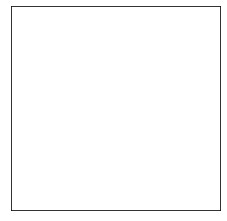

In [14]:
xmax, ymax = 15, 15
fig, ax = plt.subplots(figsize = (xmax/4, ymax/4))
plt.xticks([])
plt.yticks([])
plt.xlim([-0.2, xmax + 1.2])
plt.ylim([-0.2, ymax + 1.2])
cities, moves, t, S, E, I, R, D = simulate(xmax, ymax, density = 8/9, infected = 3, simulation_type = "SEIRD",
                                           incubation_rate = 0.2, p_infect = 0.3, p_remove = 0.2, p_death = 0.1, max_length = 400,
                                           movement = True, p_movement = 0.45, non_movers = ["D"],
                                           lthreshold = 0.05, ltemporary = False, lp_infect = 0.3, lp_movement = 0.45)
# print(str(len(cities) * xmax * ymax * 1.1) + " jobs")

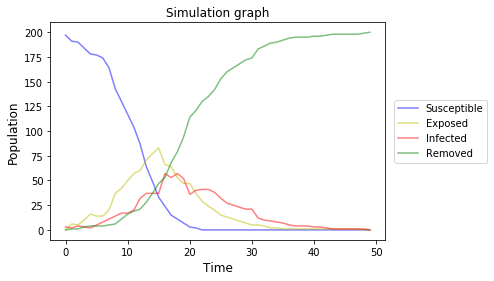

In [15]:
plt.plot(t, S, 'b', alpha = 0.5, label='Susceptible')
plt.plot(t, E, 'y', alpha = 0.5, label='Exposed')
plt.plot(t, I, 'r', alpha = 0.5, label='Infected')

plt.plot(t, np.array(R) + np.array(D), 'g', alpha = 0.5, label='Removed')

# plt.plot(t, R, 'g.', alpha = 0.5, label='Recovered')
# plt.plot(t, D, 'k.', alpha = 0.5, label='Dead')

plt.title("Simulation graph", fontsize=12)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Population", fontsize=12)
plt.legend(loc='center right', bbox_to_anchor=(1.32, 0.5));

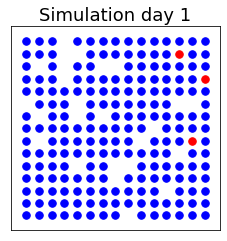

In [16]:
fig, ax = plt.subplots(figsize = (15/4, 15/4))
plt.xticks([])
plt.yticks([])
plt.xlim([-0.2, 15 + 1.2])
plt.ylim([-0.2, 15 + 1.2])

day = 1
plt.title("Simulation day " + str(day), fontsize=18)
render_city_ax((cities[day - 1]))

# Curve fitting and estimating beta

In [17]:
import scipy as sc
from scipy.integrate import odeint
from scipy.optimize import minimize

In [18]:
def dydt(y, t, N, beta, gamma, sigma):
    S, E, I, R = y
    dSdt = -beta * S * I
    dEdt = beta * S * I - sigma * E 
    dIdt = sigma * E - gamma * I
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

In [19]:
def ErrorSEIR(params):
    S, E, I, R = np.transpose(odeint(dydt, y0, t, args=tuple([population] + list(params) + [0.2, 0.2])))
    error = sum((S_data - S)**2) + sum((E_data - E)**2) + sum((I_data - I)**2) + sum((R_data - R)**2)
    return error

In [20]:
def plotSEIR_model():
    plt.plot(t, S_model, 'b', alpha = 0.2, label='Susceptible fit')
    plt.plot(t, E_model, 'y', alpha = 0.2, label='Exposed fit')
    plt.plot(t, I_model, 'r', alpha = 0.2, label='Infected fit')
    plt.plot(t, R_model, 'g', alpha = 0.2, label='Removed fit')
    
    plt.plot(t, S_data, 'b.', label='Susceptible data', markersize = 2)
    plt.plot(t, E_data, 'y.', label='Exposed data', markersize = 2)
    plt.plot(t, I_data, 'r.', label='Infected data', markersize = 2)
    plt.plot(t, R_data, 'g.', label='Removed data', markersize = 2)

    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Population", fontsize=12)
    plt.legend(loc='center right', bbox_to_anchor=(1.4, 0.5))

In [21]:
cities, moves, t, S, E, I, R, D = simulate(xmax, ymax, density = 8/9, infected = 3, simulation_type = "SEIRD",
                                           incubation_rate = 0.2, p_infect = 0.3, p_remove = 0.2, p_death = 0.1, max_length = 400,
                                           movement = True, p_movement = 0.45, non_movers = ["D"],
                                           lthreshold = 0.05, ltemporary = False, lp_infect = 0.3, lp_movement = 0.45)

[0.00861558]
62


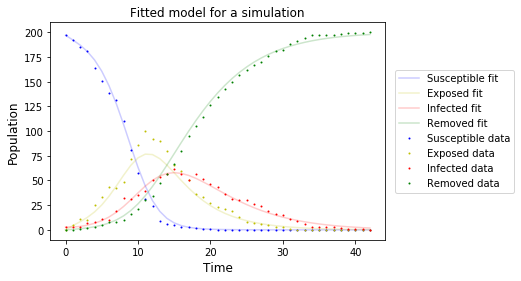

In [22]:
S_data = np.array(S)
E_data = np.array(E)
I_data = np.array(I)
R_data = np.array(R) + np.array(D)

y0 = S_data[0], E_data[0], I_data[0], R_data[0]
population = S_data[0] + E_data[0] + I_data[0] + R_data[0]

guess = [0.006]
min_params = minimize(ErrorSEIR, guess)
S_model, E_model, I_model, R_model = np.transpose(odeint(dydt, y0, t, args=tuple([population] + list(min_params.x) + [0.2, 0.2])))
print(min_params.x) # prints array which is a subset of beta, gamma, sigma
print(max(I_data))

plotSEIR_model()
plt.title("Fitted model for a simulation");

In [23]:
min_params.x[0]

0.008615578244127849

# Plotting the effect of lockdown parameters

In [25]:
from mpl_toolkits.mplot3d import axes3d

In [26]:
def peak(x, y, repeat = 10):
    '''
    Takes the average peak value of the infected curve, where lp_infect = x, lp_movement = y
    repeat: Number of trials to run and average
    '''
    global count
    peaks = []
    for i in range(repeat):
        xmax, ymax = 15, 15
        
        # manually change these details
        I = simulate(xmax, ymax, density = 8/9, infected = 3, simulation_type = "SEIRD",
                    incubation_rate = 0.2, p_infect = 0.45, p_remove = 0.2, p_death = 0.1, max_length = 400,
                    movement = True, p_movement = 0.6, non_movers = ["D"],
                    lthreshold = 0.05, ltemporary = False, lp_infect = x, lp_movement = y)[5]
        peaks.append(max(I))
    
    average = sum(peaks)/repeat
    count += 1
    
    # function runs aproximately 300 - 400 simulations per minute on my laptop
    print(str(count * repeat) + " out of " + 
          str(infect_vals.shape[0] * movement_vals.shape[0] * repeat) + " simulations finished",
          end = "\r")
    return average

peak_average = np.vectorize(peak)

In [34]:
# Recalling data
x = pd.read_csv('x_vals.csv', header = None)
y = pd.read_csv('y_vals.csv', header = None)
z = pd.read_csv('z_vals.csv', header = None)

x = np.array(x)
y = np.array(y)
z = np.array(z)

infect_vals = x[0,:]
movement_vals = y[:,0]

<Figure size 432x288 with 0 Axes>

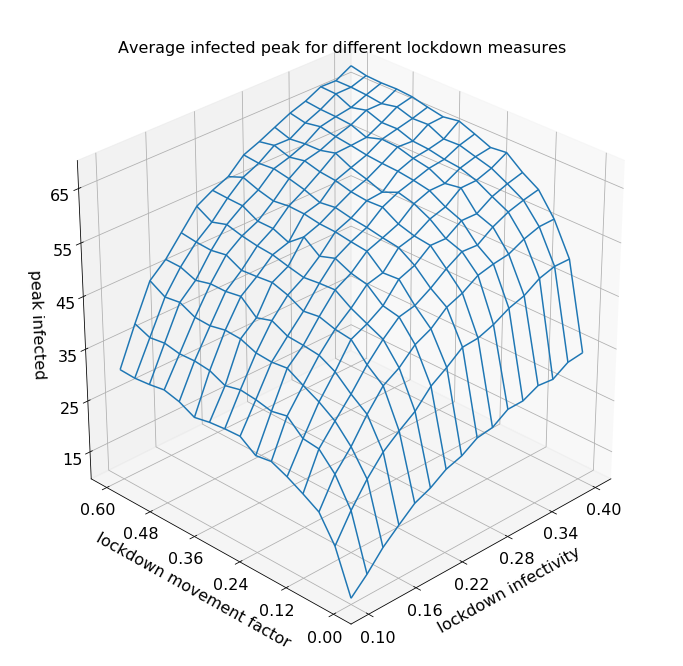

In [57]:
fig = plt.figure()
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.plot_wireframe(x[:,:], y[:,:], z[:,:])
# ax.plot(x[:,7], y[:,7], z[:,7], color="r")
# ax.plot(x[6,1:], y[6,1:], z[6,1:], color="r")

ax.set_xlabel("lockdown infectivity", fontsize=16)
ax.set_ylabel("lockdown movement factor", fontsize=16)
ax.set_zlabel("peak infected", fontsize=16)
ax.set_title("Average infected peak for different lockdown measures", fontsize=16)

ax.xaxis.labelpad=10
ax.yaxis.labelpad=10
ax.zaxis.labelpad=10

#ax.set_xlim(0, 0.5)
#ax.set_ylim(0, 0.62)
ax.set_xticks(infect_vals[::3])
ax.set_yticks(movement_vals[::3])
ax.set_zticks(np.arange(15, 66, 10))
ax.tick_params(labelsize = 16)

ax.view_init(30, 225);